# <span style='background :yellow' > MIDAS INTERNSHIP TASK 2 ( Part 2 ) </span>

#### By: Yashika Khurana

### Importing libraries

In [1]:
from PIL import Image
import cv2
import os
from PIL import ImageOps
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import keras

### Pre-processing : 
The pre-processing has been done in accordance with the pre-processing performed with the MNIST dataset to convert it into standard form.

- Extracting images from the file which includes 0-9 digits images from the provided data, appending them to data
- Extracting labels from the image names
- Converting images to (28,28)

The following steps in bullets have been taken from Medium blogs --> 

- Inverting image color
- Removing rows that are completely zero (i.e. black) to extract only the digit part. So that the model doesn't learm extra features.
- Fitting image in a 20 rows and columns 

In [3]:
data=[]
labels=[]

for i in os.listdir("numbers"):
    if str(i)==".DS_Store": # DS_Store file gets created automatically, if-condition helps ignore it
        pass
    else:
    
        for j in os.listdir("numbers/"+str(i)):
    
            link="numbers/"+str(i)+"/"+str(j)
        
            img=cv2.imread(link)
            img = cv2.resize(255-img, (28, 28))
            img=img[:,:,-1]
            img = img / 255.0
            while np.sum(img[0]) == 0:
                img = img[1:]

            while np.sum(img[:,0]) == 0:
                img = np.delete(img,0,1)

            while np.sum(img[-1]) == 0:
                img = img[:-1]

            while np.sum(img[:,-1]) == 0:
                img = np.delete(img,-1,1)

            rows,cols = img.shape
            
            if rows > cols:
                factor = 20.0/rows
                rows = 20
                cols = int(round(cols*factor))
                gray = cv2.resize(img, (cols,rows))
            else:
                factor = 20.0/cols
                cols = 20
                rows = int(round(rows*factor))
                gray = cv2.resize(img, (cols, rows))
                
            colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
            rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
            imgf = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')
            imgf -= imgf.min() 
            imgf /= imgf.max()
            imgf *= 255 # [0, 255] range
            
            data.append(imgf)
            
            #labels.append(dictionary[str(i)[6:9]])
            labels.append(str(i)[7:9])
            
            
        

### Processing the data and labels sizes before sending to the model

In [5]:
len(data)

400

In [6]:
len(labels)

400

In [7]:
data=np.asarray(data)

In [8]:
labels=np.asarray(labels)

In [9]:
data.shape

(400, 28, 28)

In [10]:
labels.shape

(400,)

In [11]:
data=data.reshape(len(data),28,28,1)

In [12]:
labels=labels.astype("uint8")

In [13]:
data.shape

(400, 28, 28, 1)

### Shuffling the data

In [14]:
import random
temp=list(zip(data,labels))
random.shuffle(temp)
data,labels=zip(*temp)

In [15]:
data=np.asarray(data)

In [16]:
labels=np.asarray(labels)

In [17]:
data.shape

(400, 28, 28, 1)

In [18]:
labels.shape

(400,)

### Building the CNN model using Keras Tuner for hyperparameter tuning

In [19]:
import keras

In [20]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
   # keras.layers.BatchNormalization(),
   # keras.layers.Activation(activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),  #1
    keras.layers.Dropout(rate=0.2),  #2
      
    
   
    keras.layers.Flatten(), #3
    keras.layers.Dense( #4
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(11, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [21]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

### Searching for best hyper-parameters by running 3 epochs

In [22]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=20,directory='output',project_name="MIDASpro")

In [23]:
tuner_search.search(data,labels,epochs=3,validation_split=0.1)

Trial 20 Complete [00h 00m 03s]
val_accuracy: 0.6499999761581421

Best val_accuracy So Far: 0.949999988079071
Total elapsed time: 00h 01m 15s
INFO:tensorflow:Oracle triggered exit


### Selecting the best model

In [24]:
fmod=tuner_search.get_best_models(num_models=1)[0]

In [25]:
fmod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 80)        2080      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 48)        96048     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 48)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 48)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4800)              0         
_________________________________________________________________
dense (Dense)                (None, 80)                384080    
_________________________________________________________________
dense_1 (Dense)              (None, 11)                8

### Training the selected model 

In [26]:
fmod.fit(data, labels, epochs=15, validation_split=0.1, initial_epoch=3)

Epoch 4/15
12/12 [==============================] - 2s 105ms/step - loss: 0.1914 - accuracy: 0.9452 - val_loss: 0.1576 - val_accuracy: 0.9500
Epoch 5/15
12/12 [==============================] - 1s 80ms/step - loss: 0.1269 - accuracy: 0.9640 - val_loss: 0.1230 - val_accuracy: 0.9250
Epoch 6/15
12/12 [==============================] - 1s 80ms/step - loss: 0.0339 - accuracy: 1.0000 - val_loss: 0.0726 - val_accuracy: 1.0000
Epoch 7/15
12/12 [==============================] - 1s 81ms/step - loss: 0.0342 - accuracy: 0.9908 - val_loss: 0.1544 - val_accuracy: 0.9250
Epoch 8/15
12/12 [==============================] - 1s 102ms/step - loss: 0.0368 - accuracy: 0.9899 - val_loss: 0.1911 - val_accuracy: 0.9000
Epoch 9/15
12/12 [==============================] - 1s 95ms/step - loss: 0.0640 - accuracy: 0.9795 - val_loss: 0.1490 - val_accuracy: 0.9250
Epoch 10/15
12/12 [==============================] - 1s 80ms/step - loss: 0.0545 - accuracy: 0.9823 - val_loss: 0.1676 - val_accuracy: 0.9500
Epoch 11/1

### Saving the model

In [27]:
fmod.save("fmod.h5")

### Importing the MNIST training data

In [28]:
dftrain=pd.read_csv("mnist_train.csv")

In [29]:
dftrain.head(n=10)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Segregating the training data into input columns and their corresponding labels 

In [30]:
full=dftrain.values

In [31]:
x=full[:,1:]
y=full[:,0]

In [32]:
x.shape

(60000, 784)

In [33]:
y.shape

(60000,)

In [34]:
a=x[0].reshape((28,28))

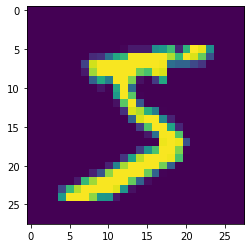

In [35]:
plt.imshow(a)

In [36]:
y[0]

5

In [37]:
len(x)

60000

In [40]:
x=x.reshape(len(x),28,28,1)

In [43]:
x.shape

(60000, 28, 28, 1)

In [44]:
y.shape

(60000,)

### Importing MNIST test data

In [46]:
dftest=pd.read_csv("mnist_test.csv")

In [48]:
test=dftest.values

### Segregating the testing data into input columns and their corresponding labels 

In [49]:
xtest=test[:,1:]
ytest=test[:,0]

In [50]:
xtest.shape

(10000, 784)

In [52]:
ytest.shape

(10000,)

In [53]:
xtest=xtest.reshape((len(xtest),28,28,1))

### Building a model for MNIST from scratch

In [54]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
   # keras.layers.BatchNormalization(),
   # keras.layers.Activation(activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),  #1
    keras.layers.Dropout(rate=0.2),  #2
      
    
   
    keras.layers.Flatten(), #3
    keras.layers.Dense( #4
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(11, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

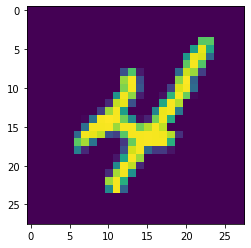

In [62]:
plt.imshow(x[9].reshape(28,28))

In [68]:
xtest.shape

(10000, 28, 28, 1)

In [69]:
ytest.shape

(10000,)

### Searching for the best model by running for 3 epochs

In [74]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [75]:
import keras

In [76]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=3,directory='output',project_name="yMidas")

In [77]:
tuner_search.search(x,y,epochs=3,validation_split=0.1)

Trial 3 Complete [00h 06m 07s]
val_accuracy: 0.9666666388511658

Best val_accuracy So Far: 0.9861666560173035
Total elapsed time: 00h 15m 37s
INFO:tensorflow:Oracle triggered exit


### Selecting the best model

In [78]:
rand_model=tuner_search.get_best_models(num_models=1)[0]

### Training the model on MNIST data

In [79]:
rand_model.fit(x, y, epochs=10, validation_split=0.1, initial_epoch=3) 

Epoch 4/10
1688/1688 [==============================] - 146s 86ms/step - loss: 0.0503 - accuracy: 0.9839 - val_loss: 0.0515 - val_accuracy: 0.9858
Epoch 5/10
1688/1688 [==============================] - 122s 72ms/step - loss: 0.0450 - accuracy: 0.9872 - val_loss: 0.0708 - val_accuracy: 0.9847
Epoch 6/10
1688/1688 [==============================] - 134s 80ms/step - loss: 0.0402 - accuracy: 0.9880 - val_loss: 0.0687 - val_accuracy: 0.9880
Epoch 7/10
1688/1688 [==============================] - 150s 89ms/step - loss: 0.0358 - accuracy: 0.9895 - val_loss: 0.0776 - val_accuracy: 0.9858
Epoch 8/10
1688/1688 [==============================] - 138s 82ms/step - loss: 0.0324 - accuracy: 0.9905 - val_loss: 0.0733 - val_accuracy: 0.9848
Epoch 9/10
1688/1688 [==============================] - 153s 91ms/step - loss: 0.0329 - accuracy: 0.9905 - val_loss: 0.0759 - val_accuracy: 0.9847
Epoch 10/10
1688/1688 [==============================] - 150s 89ms/step - loss: 0.0272 - accuracy: 0.9922 - val_loss: 

### Finding accuracy of the random model

In [81]:
score = rand_model.evaluate(xtest, ytest, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])


Test loss: 0.060136955231428146
Test accuracy: 0.9869999885559082


### The model shows 0.986 testing accuracy

### Now, training our pretrained model on MNIST

In [83]:
fmod.fit(data, labels, epochs=5, validation_split=0.1, initial_epoch=15)

In [85]:
model_new=fmod.fit(x, y, epochs=10, validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 148s 87ms/step - loss: 0.2014 - accuracy: 0.9432 - val_loss: 0.1147 - val_accuracy: 0.9642
Epoch 2/10
1688/1688 [==============================] - 145s 86ms/step - loss: 0.0806 - accuracy: 0.9757 - val_loss: 0.0673 - val_accuracy: 0.9808
Epoch 3/10
1688/1688 [==============================] - 136s 81ms/step - loss: 0.0636 - accuracy: 0.9804 - val_loss: 0.0459 - val_accuracy: 0.9882
Epoch 4/10
1688/1688 [==============================] - 139s 82ms/step - loss: 0.0556 - accuracy: 0.9831 - val_loss: 0.0581 - val_accuracy: 0.9848
Epoch 5/10
1688/1688 [==============================] - 149s 88ms/step - loss: 0.0495 - accuracy: 0.9854 - val_loss: 0.0679 - val_accuracy: 0.9847
Epoch 6/10
1688/1688 [==============================] - 166s 98ms/step - loss: 0.0440 - accuracy: 0.9868 - val_loss: 0.0529 - val_accuracy: 0.9870
Epoch 7/10
1688/1688 [==============================] - 170s 101ms/step - loss: 0.0414 - accuracy: 0.9883 - val_loss: 

In [87]:
score_new = fmod.evaluate(xtest, ytest, verbose = 0) 

print('Test loss:', score_new[0]) 
print('Test accuracy:', score_new[1])

Test loss: 0.07318665832281113
Test accuracy: 0.984000027179718


### The pretrained model shows a testing accuracy of 0.984